# Random Numbers

Here we will see some of the uses of random numbers. We will explore the transformation method. We will also look at a simple application of Monte Carlo integration and apply it to calculating $\pi$.

## Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

rng = np.random.default_rng()

Functions for generating random numbers are contained in the `np.random` module. Notice that it contains functions for many probability distributions and many utility functions for generating different types of random numbers. In practice generating random sequences of floating point numbers, integers, and bytes requires care to insure the results are not biased.

Throughout the semester, every time we have needed random numbers we used the *modern interface*. However, if you search online for information you will still find many examples that show the use of the *legacy interface*. In some ways it seems simpler to use (you do not need to generate `rng` as we have done multiple times). However, **the legacy interface should not be used in new code**. Here we will finally explore the modern way to generate random numbers.

In [ ]:
np.random?

The modern approach is to separate the *bit stream* (the algorithm that actually computes pseudo-random numbers) from the *generator* (which "generates" random number from any of a number of probability distributions).

The default *bit stream* is currently a permutation congruential
generator (`PCG64`) but others are supported, such as the Mersenne twister (`MT19937`). We do not need to know the details of the bit stream for our work.

To construct a *generator* we can use `np.random.default_rng()`.

Some more comments about random numbers are contained at the end of this example. For now we want to see what is available and to start using them.

In [ ]:
rng.

## Exponential Probability Distribution

The exponential probability distribution is useful in many contexts. In fact, we can access it from our generator as `rng.exponential`. This function allows $t$ to take any value from zero to infinity. Suppose we want to restrict our choice to a finite range.  Here we will use the transformation method to derive the mapping from the uniform distribution on the unit interval to the exponential distribution on a finite interval.

Consider the probability density
$$ P(t) \,\mathrm{d}t = N \mathrm{e}^{-t/\tau} \,\mathrm{d}t, $$
where $N$ is a normalization and $\tau$ describes the scale of the distribution. In the case of particle decays, $\tau$ would represent the lifetime of the particle. Suppose we wish to pick random numbers in the interval $t_1\le t< t_2$.

### Normalization

First we normalize the probability distribution.  This requires
$$ 1 = \int_{t_1}^{t_2} N \mathrm{e}^{-t/\tau} \,\mathrm{d}t = \tau N \left( \mathrm{e}^{-t_1/\tau} - \mathrm{e}^{-t_2/\tau} \right).  $$
Solving for the normalization constant we find
$$ \frac{1}{N} = \tau\left( \mathrm{e}^{-t_1/\tau} - \mathrm{e}^{-t_2/\tau} \right). $$

### Mapping

Next we map from a uniformly distributed random variable, $u$, on the interval $[0,1)$ to the exponential distribution.  This mapping requires
$$ u = \int_{t_1}^{t} N \mathrm{e}^{-t'/\tau} \,\mathrm{d}t' = \tau N \left( \mathrm{e}^{-t_1/\tau} - \mathrm{e}^{-t/\tau} \right). $$
We can invert this to solve for $t$.  Doing so gives the desired mapping
$$ t = -\tau \ln\left[ \mathrm{e}^{-t_1/\tau} - u \left( \mathrm{e}^{-t_1/\tau} - \mathrm{e}^{-t_2/\tau} \right) \right]. $$

### Testing the Mapping

To test the mapping consider the set of parameters $\tau=1.5$, $t_1=0.7$, $t_2=5$.  We will generate a large set of uniformly distributed random numbers and apply the mapping.  To verify that it has the correct distribution we create a histogram using `hist` and plot it along with the true probability distribution.  Note that the true probability distribution is normalized (we did this above to find $N$) thus we must also normalize the histogram.  This is accomplished using the `density` keyword argument to `hist`. (An older way of doing this was to use the `normed` keyword argument.  That is now deprecated and you will get a warning if you use it.)

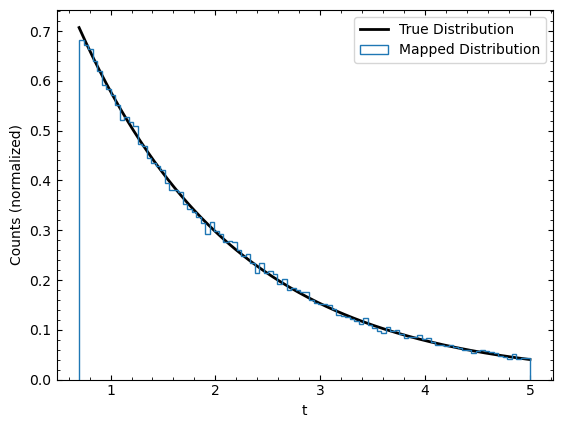

In [2]:
tau = 1.5
t1 = 0.7
t2 = 5.0

# Normalization
N = 1 / (tau * (np.exp(-t1/tau) - np.exp(-t2/tau)))

# Probability distribution
def P(t):
    return N * np.exp(-t / tau)

# Generate uniformly distributed random numbers
n = 100000
u = rng.random(size=n)

# Map them to the exponential distribution
t = -tau * np.log(np.exp(-t1/tau) - u*(np.exp(-t1/tau) - np.exp(-t2/tau)))

tfine = np.linspace(t1, t2, 200)

# Plot the results
plt.plot(tfine, P(tfine), 'k-', lw=2, label='True Distribution')
plt.hist(t, bins=100, histtype='step', density=True, label='Mapped Distribution')
plt.xlabel('t')
plt.ylabel('Counts (normalized)')
plt.legend();

## Uniformly Sample the Disk

To uniformly sample the area of a disk we do **not** uniformly sample in $r$ and $\theta$. To see this let us try uniformly sampling inside the unit circle.

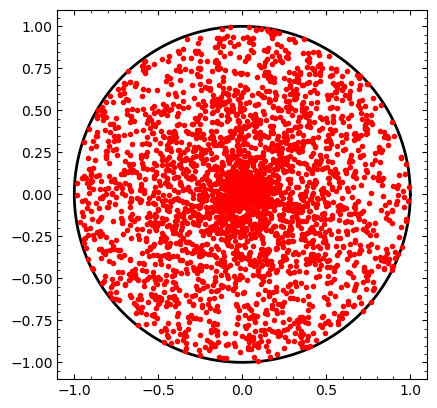

In [3]:
# For the edge of the circle:
theta_circle = np.linspace(0, 2*np.pi, 1000)
X = np.cos(theta_circle)
Y = np.sin(theta_circle)

N = 3000
r = rng.random(size=N)
theta = 2*np.pi * rng.random(size=N)
x = r*np.cos(theta)
y = r*np.sin(theta)

fig = plt.figure()
ax = fig.add_subplot(111, aspect=1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.plot(X, Y, 'k-', lw=2)
ax.plot(x, y, 'r.');

Notice that there are far more points near the center of the circle than there are near the edges. This makes sense. Consider two points separated by a small difference in $\theta$. For $r$ small these two points would be very near each other. On the other hand, for a larger $r$ they would be much further apart. Clearly we should not uniformly sample in both $r$ and $\theta$, so, how should we sample?

Recall that the area element written in Cartesian coordinates is just $\mathrm{d}A = \mathrm{d}x\, \mathrm{d}y$. However, in polar coordinates it is written as $\mathrm{d}A = r\mathrm{d}r\, \mathrm{d}\theta$. This effects how we calculate probabilities.  For a uniform distribution in Cartesian coordinates the probability of finding $0\le x' < x$ and $0\le y' < y$ is given by
$$ P_{\mathrm{Cartesian}}(x,y) = \int_0^x \mathrm{d}x' \int_0^y \mathrm{d}y'. $$
Notice that $x$ and $y$ separate, the two integrals are independent of each other, so we can treat $x$ and $y$ as two independent uniformly distributed random variables. This means uniformly sampling the square is easy, just pick $x$ and $y$ independently.

In polar coordinates things are different. The probability of finding $0\le r'< r$ and $0\le\theta'<\theta$ is given by
$$ P_{\mathrm{polar}}(r,\theta) = \frac{1}{\pi} \int_0^r r'\,\mathrm{d}r' \int_0^{\theta} \mathrm{d}\theta'. $$
We see that again $r$ and $\theta$ are independent of each other. We also see that the probability distribution does not depend on $\theta$ so we can treat $\theta$ as a uniformly distributed random number, but we *cannot do the same* for $r$. Instead we see that
$$ p(r) \,\mathrm{d}r \propto r \,\mathrm{d}r. $$
As we saw in class, if $u$ is a uniformly distributed random number, then we can relate it to one that has a linear probability density by $r=\sqrt{u}$. Thus we can remap the random numbers calculated above to uniformly sample the disk.

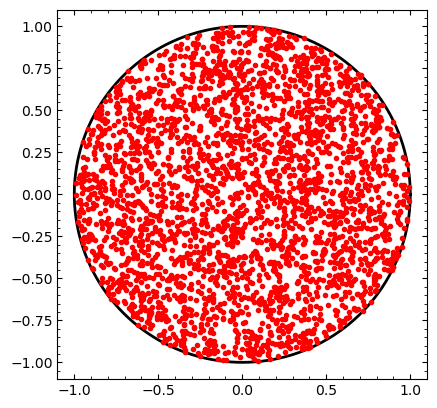

In [4]:
# We do NOT change the random numbers.  We reuse the ones we calculated
# above and just remap them.
R = np.sqrt(r)

x = R*np.cos(theta)
y = R*np.sin(theta)

fig = plt.figure()
ax = fig.add_subplot(111, aspect=1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.plot(X, Y, 'k-', lw=2)
ax.plot(x, y, 'r.');

Now we have uniformly sampled the circle!

## Calculating $\pi$ with Shotgun

How would you estimate $\pi$ if you only had a shotgun on hand? Why you would have a shotgun but not some other basic device that could help you determine $\pi$ I do not know, but this question has been been answered as can be seen in an [ArXiv blog post](https://medium.com/the-physics-arxiv-blog/how-mathematicians-used-a-pump-action-shotgun-to-estimate-pi-c1eb776193ef). In fact it is a standard problem using the rejection method for performing Monte Carlo integration. (Actually, when applied to the case of using a shotgun it involves importance sampling, the details of which we did not discuss but builds on topics we have discussed.)

The idea is fairly simple. Consider the unit circle. We can enclose this inside a square with sides of length 2. Mathematically we know the areas of the two objects,
$$ A_{\mathrm{square}} = 4 \quad\mathrm{and}\quad A_{\mathrm{circle}} = \pi. $$
Numerically, if we uniformly sample $N_{\mathrm{square}}$ points inside the square, something that is easy to do as discussed above, then some number of them will also fall inside the circle. We can count this number and will call it $N_{\mathrm{circle}}$. The ratio of the number of points that fall inside the circle to the total number of points will be nothing more than the ratio of the area of the circle to the area of the square. In other words,
$$ \frac{N_{\mathrm{circle}}}{N_{\mathrm{square}}} = \frac{A_{\mathrm{circle}}}{A_{\mathrm{square}}} = \frac{\pi}{4}, $$
so
$$ \pi = 4 \frac{N_{\mathrm{circle}}}{N_{\mathrm{square}}}. $$
This we can easily calculate!

Consider an example with $N_{\mathrm{square}} = 100,000$.

In [5]:
N = 100_000
# pick x and y in interval (-1, 1)
x = 2*rng.random(N) - 1
y = 2*rng.random(N) - 1
# find those inside the unit circle
ind, = np.where(x**2 + y**2 <= 1)
# count them
Ncircle = len(ind)
# Estimate pi
pi_est = (4.0 * Ncircle) / N
print(f"pi estimate : {pi_est} has fractional error {100 * np.abs(1 - pi_est/np.pi)}%")

pi estimate : 3.14108 has fractional error 0.016318270581872074%


Using 100,000 points we see we get about 3 digits of accuracy. To go beyond this we should find the accuracy as a function of the number of points sampled. Further, since we are using random numbers we will not get the exact same answer each time so we will average over a few samples.

Here we write a function to do the hard work for us. I have sped it up by not using two loops for the computations. The calculations are much faster without using a double loop, that is, if you do not run out of RAM by trying to calculate too much at once! So, be careful when running this, particularly for larger values of `N`!

In [6]:
def pi_MC(N, ntries):
    """
    Monte Carlo estimate of pi using the rejection method.
    Random points are chosen inside a square with sides of length 2.
    The ratio of the number of points inside the unit circle centered at the middle
    of the circle to the total number of points generated is pi/4.
    N points are generated for each of ntries realizations.
    Returned is an array containing the estimate of pi for each realization.
    """
    # Generate all the realizations at once.  This is significantly
    # faster than using a loop!
    x = 2*rng.random(size=(ntries, N)) - 1
    y = 2*rng.random(size=(ntries, N)) - 1
    # find those inside the unit circle
    ind = (x**2 + y**2 <= 1)
    # Count them.
    # Here we use the fact the True=1 and False=0
    Ncircle = np.sum(ind, axis=-1)
    # Estimate pi
    return (4.0 * Ncircle) / N

Narr = np.logspace(3, 6, 8).astype(int)
ntries = 100
pi_est = np.zeros((len(Narr), ntries))
# Here we do need to loop over each number of points
# we wish to generate.
for i in range(len(Narr)):
    pi_est[i] = pi_MC(Narr[i], ntries)
pi_avg_err = np.mean(np.abs(pi_est - np.pi), axis=1)

Next we look at the average errors as a function of the number of points sampled. The major downside with using Monte Carlo integration is that it converges very slowly. It behaves like a random walk so the error is expected to decrease only as the square root of the number of samples. We see this in the results.

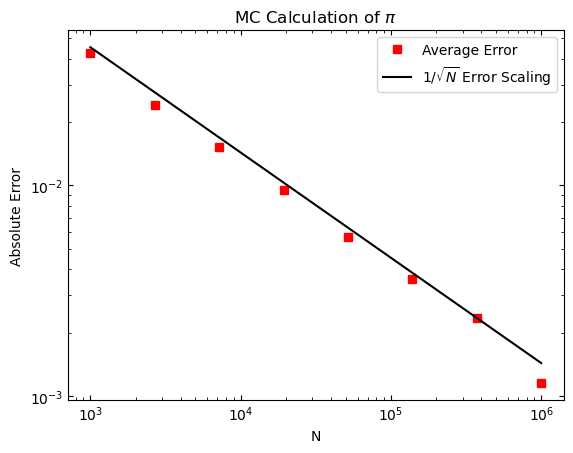

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.loglog(Narr, pi_avg_err, 'rs', label='Average Error')
A = np.sqrt(Narr[-2]) * pi_avg_err[-2]
n = np.logspace(3, 6, 100)
ax.loglog(n, A/np.sqrt(n), 'k-', label=r'$1/\sqrt{N}$ Error Scaling')
ax.legend(numpoints=1)
ax.set_xlabel('N')
ax.set_ylabel('Absolute Error')
ax.set_title(r'MC Calculation of $\pi$');

## Multiple Random Streams and Reproducibility

It was mentioned in class that pseudo-random numbers are preferable to cryptographically secure random numbers for scientific applications since a scientific result should be reproducible. In the "old days" a random number generator took an integer as a seed. Knowing this integer and the algorithm used for generating our pseudo-random numbers we could reproduce the sequence at some later time. This can still be done when greating our *bitstream*. The best way to do this is to use `np.random.SeedSequence()`.

Note that it is rare to actually save the state information. Typically we perform our calculations starting from an unknown state and do not worry about it. Of course the results should *not depend* on the state of the random number generator, this is an important test of the results in general. In practice I have only found the need to worry about this while debugging code. If "something funny happens" it is quite useful to be able to repeat it as you try to find the source of the problem.

To get reproducibility the recommended way to do things is to create a random `SeedSequence` and then save this information. Let us see how this works.

In [ ]:
np.random.SeedSequence?

First we create a seed. The important information is the `entropy`. With this number we can reset/reproduce the stream as long as we use the same *bit stream*.

In [8]:
seq = np.random.SeedSequence()
print(seq)

SeedSequence(
    entropy=196072460036852104614157105402756939403,
)


As an example, suppose we create two random number generators with the same seed.

In [9]:
rng1 = np.random.default_rng(seq)
rng2 = np.random.default_rng(seq)

Now, when we generate random numbers from the two streams we get exactly the same values.

In [10]:
print(f"""
rng1 gives {rng1.random(10)}
rng2 gives {rng2.random(10)}
""")


rng1 gives [0.16472141 0.57753563 0.22158557 0.46553374 0.76887069 0.61609754
 0.49962804 0.34502506 0.46225126 0.92171001]
rng2 gives [0.16472141 0.57753563 0.22158557 0.46553374 0.76887069 0.61609754
 0.49962804 0.34502506 0.46225126 0.92171001]



If we generate more numbers from one of them we get new numbers.

In [11]:
print(rng1.random(10))

[0.14122239 0.22769875 0.70261047 0.03240202 0.95609914 0.4882764
 0.68360494 0.91036895 0.16163457 0.11954046]


We can reset to the initial state and will then get the same numbers we started with.

In [12]:
rng1 = np.random.default_rng(seq)
print(rng1.random(10))

[0.16472141 0.57753563 0.22158557 0.46553374 0.76887069 0.61609754
 0.49962804 0.34502506 0.46225126 0.92171001]


Related to this we may want or need multiple independent streams of random numbers. We *do not* want to use the same stream in multiple processes. Remember that we are using a pseudo-random number generator. This means if we are in the same state, we will get the same numbers. This requires care particularly important in multi-threaded programs.  Though this is beyond the scope of what we need, it does come up (we use computers with multiple cores so it is quite reasonable to want to use them). The documentation for the bit streams tell use how to properly generate multiple streams from the same `SeedSequence`.

In [ ]:
np.random.PCG64?

For example, to generator 4 independent streams we can use the following.

In [13]:
# First create a seed. We will explicitly choose a seed this time, this is not necessary.
seq = np.random.SeedSequence(4321)
print(f"Sequence entropy: {seq.entropy}")
rngs= [np.random.default_rng(s) for s in seq.spawn(4)]
print(rngs)

Sequence entropy: 4321
[Generator(PCG64) at 0x7FD48040F920, Generator(PCG64) at 0x7FD48040F4C0, Generator(PCG64) at 0x7FD48040F140, Generator(PCG64) at 0x7FD48040C120]


The main message is that care must be taken when working with random numbers. In cryptographic cases this is even more true, extreme care must be taken to not make a mistake which allows information an attacker can use to leak out. (There are many examples of such errors.) Even in scientific settings, the use of bad random number generators or incorrectly using them can lead to biased results. It is always best to test results to be sure they make sense. Using different *bit streams* can help: the statistical properties of the results should not change using different streams.